In [86]:
import seaborn as sns
from IPython.display import display

In [2]:
import pandas as pd
import seaborn as sns
import tqdm
import numpy as np
import json
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score
%matplotlib inline

In [3]:
srp = pd.read_csv('survey_results_public.csv')
srs = pd.read_csv('survey_results_schema.csv')

/home/denis/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (8,12,13,14,15,16,50,51,52,53,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [13]:
devtype = set(sum([s.split(';') for s in srp.DevType.dropna().unique()], []))

In [14]:
features = dict()
features_nuinique = dict()
features_conctated = dict()
for key in srp.keys():
    lst = []
    max_parts_num = 0
    for s in srp[key].dropna().unique():
        if type(s) == str:
            parts = s.split(';')
            max_parts_num = max(max_parts_num, len(parts))
            lst += parts
        else:
            max_parts_num = 1
            lst += [s]
    features[key] = list(sorted(set(lst)))
    features_nuinique[key] = len(features[key])
    features_conctated[key] = max_parts_num

In [15]:
sorting_features = []
group_features = []
continius_features = []
categorical_features = []

cat_max = 50
for fname in features:
    if fname[-1].isdigit():
        sorting_features.append(fname)
    else:
        if features_conctated[fname] > 1:
            group_features.append(fname)
        else:
            if features_nuinique[fname] > cat_max:
                continius_features.append(fname)
            else:
                categorical_features.append(fname)
                
sorting_features = sorted(sorting_features)
group_features = sorted(group_features)
continius_features = sorted(continius_features)
categorical_features = sorted(categorical_features)

In [16]:
len(sorting_features)

51

In [17]:
len(categorical_features)

51

In [18]:
psevdo_categorical = \
    ['WakeTime','YearsCoding','YearsCodingProf',
    'StackOverflowRecommend', 'StackOverflowJobsRecommend',
    'Age', 'StackOverflowVisit', 'StackOverflowParticipate','CheckInCode',
    'NumberMonitors','HoursOutside', 'LastNewJob','HoursComputer',
    'SkipMeals','Exercise',
    'TimeAfterBootcamp', 'TimeFullyProductive', 'CompanySize']

len(psevdo_categorical)

18

In [19]:
convert_psevdo_categorical = {
    'WakeTime':{
        'After 12:01 PM':13,
       'Before 5:00 AM':4,
       'Between 10:01 - 11:00 AM':10,
       'Between 11:01 AM - 12:00 PM':11,
       'Between 5:00 - 6:00 AM':5,
       'Between 6:01 - 7:00 AM':6,
       'Between 7:01 - 8:00 AM':7,
       'Between 8:01 - 9:00 AM':8,
       'Between 9:01 - 10:00 AM':9,
       'I do not have a set schedule':None,
       'I work night shifts':0,
    },
    'YearsCoding':
      {'0-2 years':1,
       '12-14 years':13,
       '15-17 years':15,
       '18-20 years':18,
       '21-23 years':21,
       '24-26 years':24,
       '27-29 years':27,
       '3-5 years':3,
       '30 or more years':30,
       '6-8 years':6,
       '9-11 years':9},
    'YearsCodingProf':
      {'0-2 years':1,
       '12-14 years':13,
       '15-17 years':15,
       '18-20 years':18,
       '21-23 years':21,
       '24-26 years':24,
       '27-29 years':27,
       '3-5 years':3,
       '30 or more years':30,
       '6-8 years':6,
       '9-11 years':9},
    'StackOverflowRecommend':{
        '0 (Not Likely)':0,
        '1':1,
        '10 (Very Likely)':10,
        '2':2,
        '3':3,
        '4':4,
        '5':5,
        '6':6,
        '7':7,
        '8':8,
        '9':9
    },
    'StackOverflowJobsRecommend':{
        '0 (Not Likely)':0,
        '1':1,
        '10 (Very Likely)':10,
        '2':2,
        '3':3,
        '4':4,
        '5':5,
        '6':6,
        '7':7,
        '8':8,
        '9':9
    },
    'Age':
      {'18 - 24 years old':20,
       '25 - 34 years old':30,
       '35 - 44 years old':40,
       '45 - 54 years old':50,
       '55 - 64 years old':60,
       '65 years or older':70,
       'Under 18 years old':15},
    'StackOverflowVisit':{
        'A few times per month or weekly':30,
        'A few times per week':100,
        'Daily or almost daily':365,
        'I have never visited Stack Overflow (before today)':1,
        'Less than once per month or monthly':10,
        'Multiple times per day':1000
    },
    'StackOverflowParticipate':{
        'A few times per month or weekly':30,
        'A few times per week':100,
        'Daily or almost daily':365,
        'I have never visited Stack Overflow (before today)':1,
        'Less than once per month or monthly':10,
        'Multiple times per day':1000
    },
    'CheckInCode':{
        'A few times per month or weekly':30,
        'A few times per week':100,
        'Daily or almost daily':365,
        'I have never visited Stack Overflow (before today)':1,
        'Less than once per month or monthly':10,
        'Multiple times per day':1000
    },
    'NumberMonitors': 
        {'1':1, '2':2, '3':3, '4':4, 'More than 4':5.5},
    'HoursOutside':{
        '1 - 2 hours':1.5,
        '3 - 4 hours':3.5,
        '30 - 59 minutes':0.6,
        'Less than 30 minutes':0.3,
        'Over 4 hours':5
    },
    'LastNewJob':{
        'Between 1 and 2 years ago':1.5,
        'Between 2 and 4 years ago':3,
        "I've never had a job":None,
        'Less than a year ago':0.5,
        'More than 4 years ago':5.5,
    },
    'HoursComputer':{
        '1 - 4 hours':3,
        '5 - 8 hours':6,
        '9 - 12 hours':10,
        'Less than 1 hour':0.5,
        'Over 12 hours': 13
    },
    'SkipMeals':{
        '1 - 2 times per week':1.5,
        '3 - 4 times per week':3.5,
        'Daily or almost every day':7,
        'Never':0
    },
    'Exercise':{
        '1 - 2 times per week':1.5,
        '3 - 4 times per week':3.5,
        'Daily or almost every day':7,
        "I don't typically exercise":0
    },
    'TimeAfterBootcamp':{
        'Four to six months':0.4,
        'I already had a full-time job as a developer when I began the program':-1,
        'I haven\xe2\x80\x99t gotten a developer job':None,
        'Immediately after graduating':0.0,
        'Less than a month':0.07,
        'Longer than a year':1.5,
        'One to three months':0.2,
        'Six months to a year':0.7,
    },
    'TimeFullyProductive':{
        'Less than a month':0.7,
        'More than a year':15,
        'Nine months to a year':11,
        'One to three months':2,
        'Six to nine months':7,
        'Three to six months':4
    },
    'CompanySize':{
        '1,000 to 4,999 employees':3000,
       '10 to 19 employees':15,
       '10,000 or more employees':20000,
       '100 to 499 employees':300,
       '20 to 99 employees':50,
       '5,000 to 9,999 employees':7000,
       '500 to 999 employees':7000,
       'Fewer than 10 employees':5,
    }
}   

In [20]:
categorical_features += ['Country', 'CurrencySymbol']
continios = ['ConvertedSalary']

In [21]:
i =0
keys = dict()
for f in categorical_features:
    if f in convert_psevdo_categorical:
        keys[f] = i
        i += 1
    else:
        for f_val in features[f]:
            keys[f + ' _:_ ' + f_val] = i
            i += 1
            
for f in group_features:
    for f_val in features[f]:
        keys[f + ' : ' + f_val] = i
        i += 1
    keys[f + ' _:_ ' + 'sum'] = i
    i += 1
    
for f in continios:
    keys[f] = i
    i += 1

In [45]:
json.dump(keys, open('keys.json', 'w'))

In [22]:
keys['LanguageWorkedWith : Python']

705

In [ ]:
res = np.zeros((len(srp), len(keys)))
for i in tqdm.tqdm_notebook(range(len(srp))):
    d = dict()
    elem = srp.iloc[i]
    for f in categorical_features:
        if f in convert_psevdo_categorical:
            convert = convert_psevdo_categorical[f]
            if elem[f] in convert:
                res[i, keys[f]] = convert[elem[f]]
            else:
                res[i, keys[f]] = None
        else:
            for f_val in features[f]:
                res[i, keys[f + ' _:_ ' + f_val]] = int(elem[f] == f_val)

    for f in group_features:
        sum_group = 0
        for f_val in features[f]:
            val = int(f_val in elem[f].split(';')) if type(elem[f])==str  else 0
            res[i, keys[f + ' : ' + f_val]] = val
            sum_group += val
        res[i, keys[f + ' _:_ ' + 'sum']] = sum_group

    for f in continios:
        res[i, keys[f]] = elem[f]

In [55]:
res = res[:6200]

In [24]:
res = np.load(open('./data.np', 'rb'))
keys_list = json.load(open('./keys.json'))

In [26]:
keys_list = sorted(keys, key = lambda k: keys[k])

In [27]:
df = pd.DataFrame(data=res, columns=keys_list)

In [3]:
df = pd.read_csv('data.csv')

In [4]:
keys_list = df.keys()

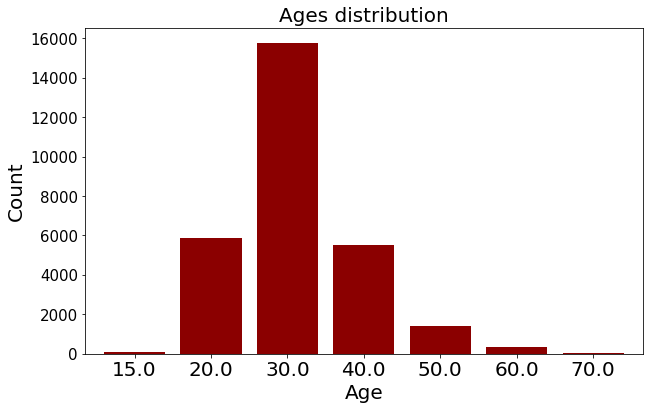

In [85]:
plt.figure(figsize=(10, 6))
df.groupby('Age').size().plot.bar(
    width=0.8, color='darkred', rot=0)
plt.title('Ages distribution', size=20)
plt.xticks(size=20)
plt.yticks(size=15)
plt.xlabel('Age', size=20)
plt.ylabel('Count', size=20);
#plt.savefig('images/1.pdf')
#plt.show()

In [131]:
d = df[feature_names]

In [137]:
s = d.sum()

In [144]:
topn = 10
s = d.sum()
keys = s.sort_values(ascending=False)[:topn].keys()
d = d[keys]

In [109]:
def plot_group_correlation(topn, group_feature):
    feature_names = [x for x in keys_list if x.startswith(group_feature) and '_:_ sum' not in x] 
    plt.figure(figsize=(10, 8))
    plt.title(group_feature + ' correlation', size=20)
    
    d = df[feature_names]
    s = d.sum()
    keys = s.sort_values(ascending=False)[:topn].keys()
    d = d[keys]
    
    corr = d.corr('spearman')
    names = [x.split(': ')[1][:15] for x in corr.index]
    corr.index = names
    corr.columns = names
    palette = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(corr, vmin=-1, vmax=1, cmap=palette);

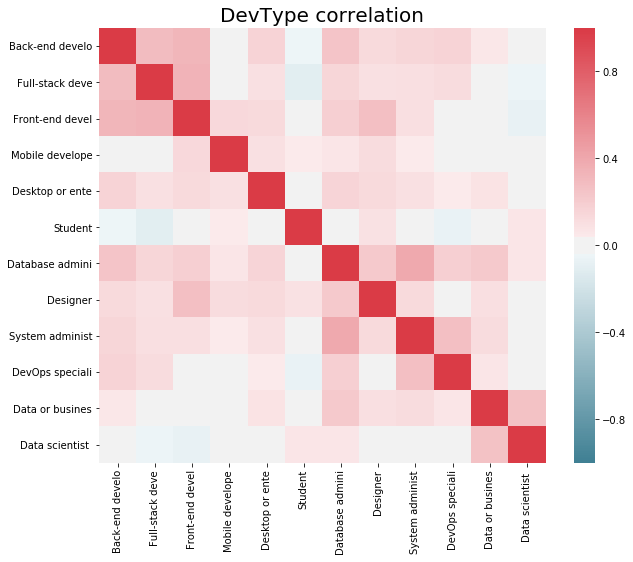

In [112]:
plot_group_correlation(12, 'DevType')

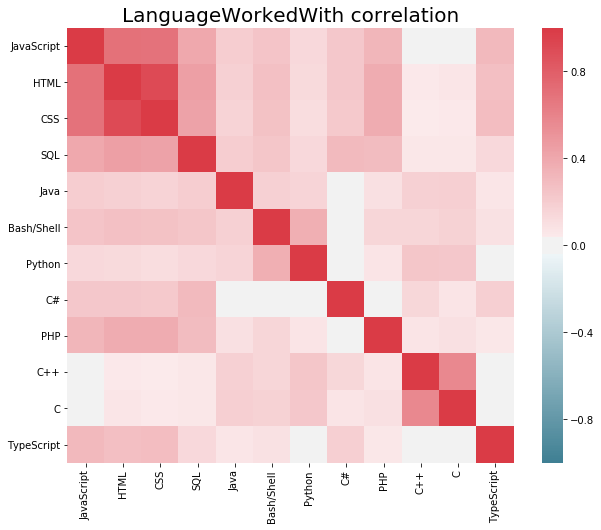

In [155]:
plot_group_correlation(12, 'LanguageWorkedWith')

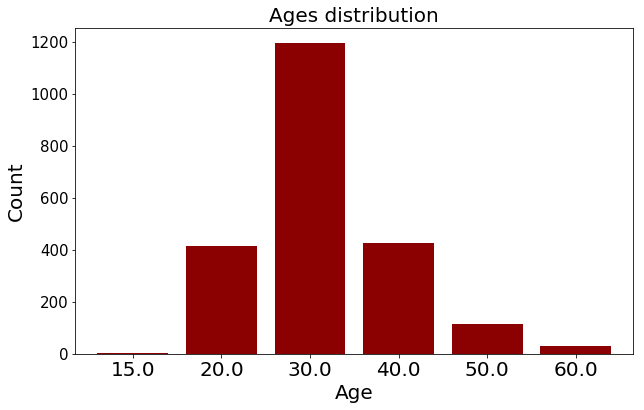

In [164]:
datascientists = df[df['DevType : Data scientist or machine learning specialist'] == 1.0]
plt.figure(figsize=(10, 6))
datascientists.groupby('Age').size().plot.bar(
    width=0.8, color='darkred', rot=0)
plt.title('Ages distribution', size=20)
plt.xticks(size=20)
plt.yticks(size=15)
plt.xlabel('Age', size=20)
plt.ylabel('Count', size=20);

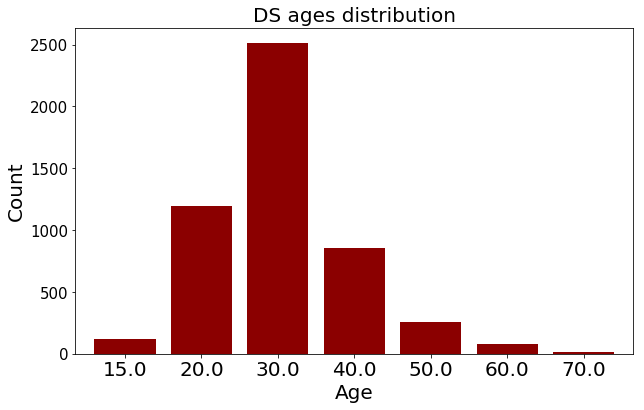

In [114]:
datascientists = df[
    (df['DevType : Data scientist or machine learning specialist'] == 1.0)
                   ]
plt.figure(figsize=(10, 6))
datascientists.groupby('Age').size().plot.bar(
    width=0.8, color='darkred', rot=0)
plt.title('DS ages distribution', size=20)
plt.xticks(size=20)
plt.yticks(size=15)
plt.xlabel('Age', size=20)
plt.ylabel('Count', size=20);

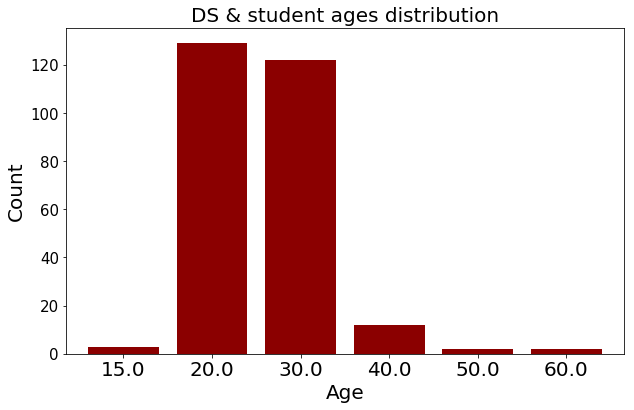

In [173]:
datascientists = df[
    (df['DevType : Data scientist or machine learning specialist'] == 1.0)&
    (df['DevType : Student'] == 1.0)
                   ]
plt.figure(figsize=(10, 6))
datascientists.groupby('Age').size().plot.bar(
    width=0.8, color='darkred', rot=0)
plt.title('DS & student ages distribution', size=20)
plt.xticks(size=20)
plt.yticks(size=15)
plt.xlabel('Age', size=20)
plt.ylabel('Count', size=20);

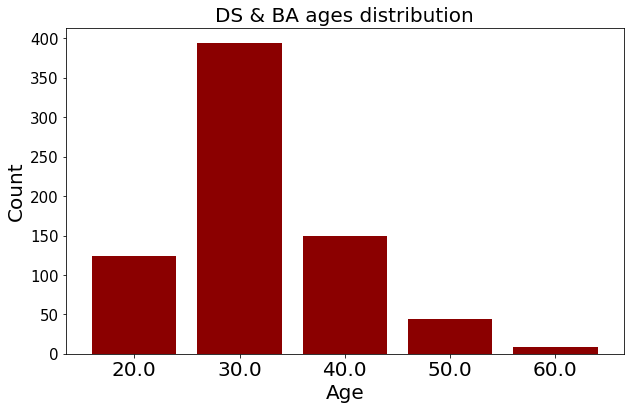

In [174]:
datascientists = df[
    (df['DevType : Data scientist or machine learning specialist'] == 1.0)&
    (df['DevType : Data or business analyst'] == 1.0)
                   ]
plt.figure(figsize=(10, 6))
datascientists.groupby('Age').size().plot.bar(
    width=0.8, color='darkred', rot=0)
plt.title('DS & BA ages distribution', size=20)
plt.xticks(size=20)
plt.yticks(size=15)
plt.xlabel('Age', size=20)
plt.ylabel('Count', size=20);

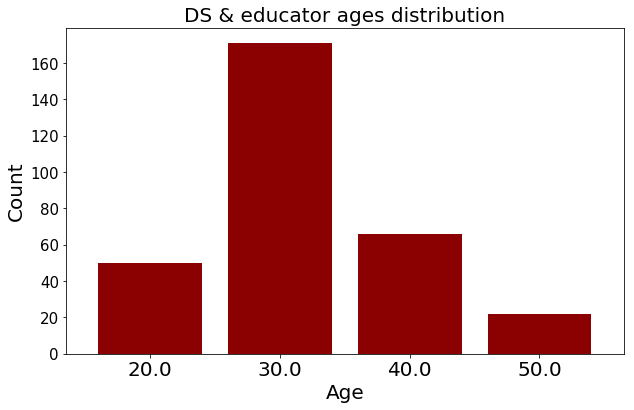

In [176]:
datascientists = df[
    (df['DevType : Data scientist or machine learning specialist'] == 1.0)&
    (df['DevType : Educator or academic researcher'] == 1.0)
                   ]
plt.figure(figsize=(10, 6))
ages = datascientists.groupby('Age').size()
ages[ages > 15].plot.bar(
    width=0.8, color='darkred', rot=0)
plt.title('DS & educator ages distribution', size=20)
plt.xticks(size=20)
plt.yticks(size=15)
plt.xlabel('Age', size=20)
plt.ylabel('Count', size=20);

In [ ]:
df.corrwith()

Text(0.5,0,'Age')

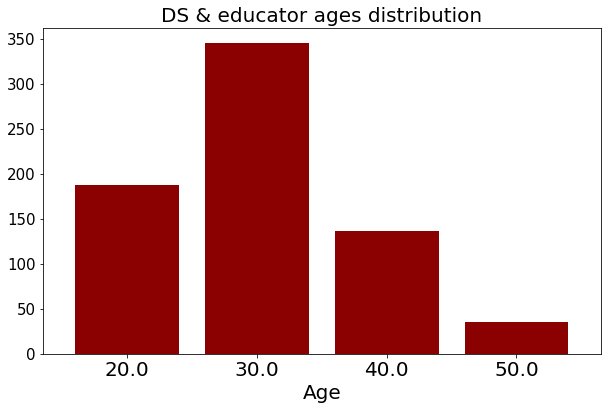

In [177]:
datascientists = df[
    (df['DevType : Data scientist or machine learning specialist'] == 1.0)&
    (df['LanguageWorkedWith : C++'] == 1.0)
                   ]
plt.figure(figsize=(10, 6))
ages = datascientists.groupby('Age').size()
ages[ages > 15].plot.bar(
    width=0.8, color='darkred', rot=0)
plt.title('DS & educator ages distribution', size=20)
plt.xticks(size=20)
plt.yticks(size=15)
plt.xlabel('Age', size=20)

In [202]:
def plot_pair_correlation(group_feature1, group_feature2, topn=10):
    feature_names1 = [x for x in keys_list if x.startswith(group_feature1) and '_:_ sum' not in x] 
    feature_names2 = [x for x in keys_list if x.startswith(group_feature2) and '_:_ sum' not in x]
    
    plt.figure(figsize=(10, 8))
    plt.title(group_feature1 +' with ' + group_feature2 + ' correlation', size=20)
    
    d1 = df[feature_names1]
    d2 = df[feature_names2]
    
    s = d1.sum()
    keys = s.sort_values(ascending=False)[:topn].keys()
    d1 = d1[keys]
    
    s = d2.sum()
    keys = s.sort_values(ascending=False)[:topn].keys()
    d2 = d2[keys]
    
    
    corr = d1.corrwith(d2)
    return d1, d2
    #names = [x.split(': ')[1][:15] for x in corr.index]
    #corr.index = names
    #corr.columns = names
    palette = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(corr, vmin=-1, vmax=1, cmap=palette);

In [79]:
def plot_pair_correlation(group_feature1, group_feature2, topn=10, top_symbols = [15,15]):
    feature_names1 = [x for x in keys_list if x.startswith(group_feature1) and '_:_ sum' not in x] 
    feature_names2 = [x for x in keys_list if x.startswith(group_feature2) and '_:_ sum' not in x]

    plt.figure(figsize=(10, 8))
    plt.title(group_feature1 +' with ' + group_feature2 + ' correlation', size=20)

    d1 = df[feature_names1]
    d2 = df[feature_names2]

    s = d1.sum()
    keys1 = s.sort_values(ascending=False)[:topn].keys()

    s = d2.sum()
    keys2 = s.sort_values(ascending=False)[:topn].keys()

    d = df[list(keys1) + list(keys2)]
    corr = d.corr('pearson').filter(keys2).drop(keys2)

    corr.index = [x.split(': ')[1][:top_symbols[0]] for x in corr.index]
    corr.columns = [x.split(': ')[1][:top_symbols[1]] for x in corr.columns]
    palette = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(corr, vmin=-1, vmax=1, cmap=palette);

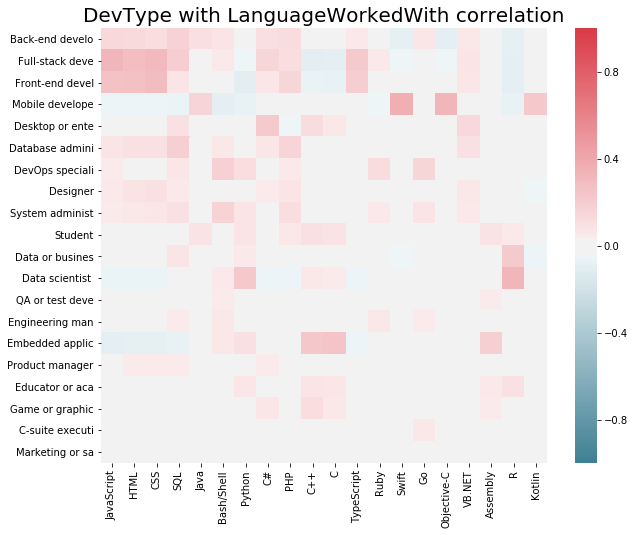

In [68]:
plot_pair_correlation('DevType', 'LanguageWorkedWith', 20)

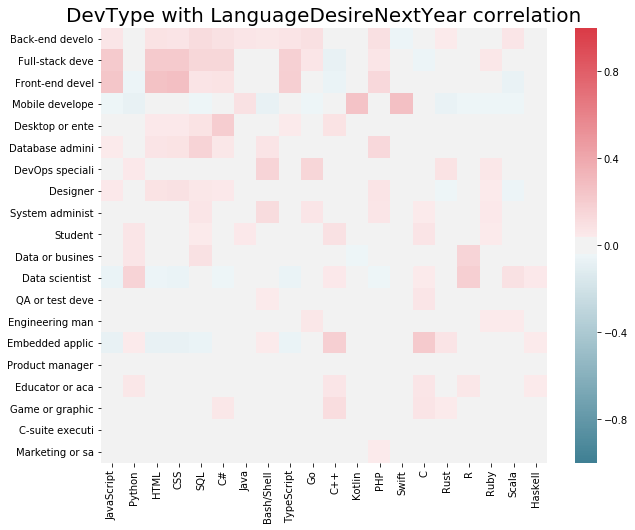

In [69]:
plot_pair_correlation('DevType', 'LanguageDesireNextYear', 20)

In [10]:
d2.shape

(98855, 10)

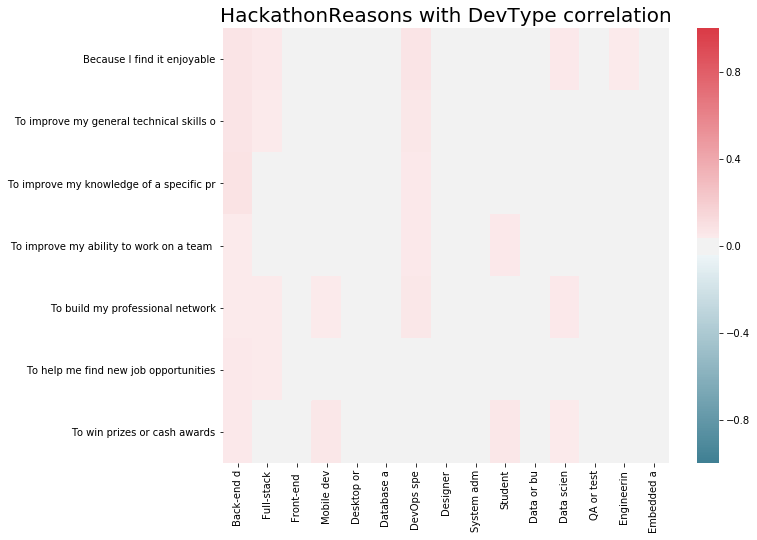

In [80]:
plot_pair_correlation('HackathonReasons', 'DevType', 15, [40, 10])

In [9]:
d = df[df['Country _:_ United States'] == 1.0].groupby('LanguageWorkedWith _:_ sum')
number_of_lang_salary_usa = d.median()[d.size() > 100].ConvertedSalary.dropna().drop(0)
number_of_lang_users_usa = d.size()[d.size() > 100].drop(0)

In [34]:
d = df[df['Country _:_ Russian Federation'] == 1.0]

d = d.groupby('LanguageWorkedWith _:_ sum')
number_of_lang_salary_rf = d.median()[d.size() > 15].ConvertedSalary.dropna().drop(0)
number_of_lang_users_rf = d.size()[d.size() > 15].drop(0)

In [39]:
d = df

d = d.groupby('LanguageWorkedWith _:_ sum')
number_of_lang_salary_world = d.median()[d.size() > 500].ConvertedSalary.dropna().drop(0)
number_of_lang_users_world = d.size()[d.size() > 500].drop(0)

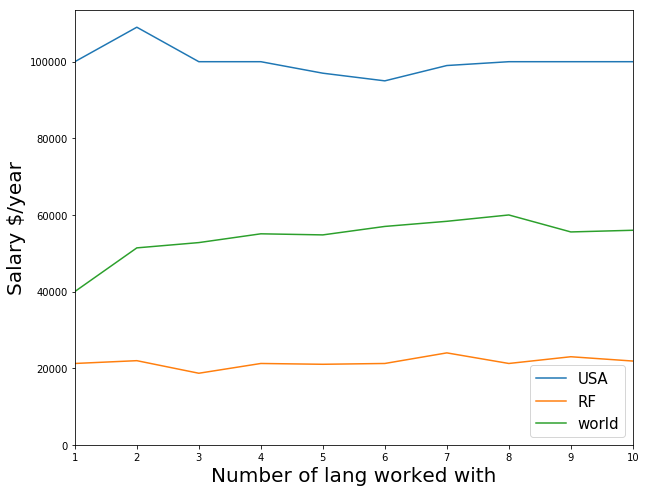

In [66]:
fig = plt.figure(figsize=(10,8))

number_of_lang_salary_usa.plot(label='USA', legend=True)
number_of_lang_salary_rf.plot(label='RF', legend=True)
number_of_lang_salary_world.plot(label='world', legend=True)

plt.xlabel('Number of lang worked with', size =20)
plt.ylabel('Salary $/year', size =20)
plt.ylim(ymin=0)
plt.xlim(xmax=10)
plt.legend(prop={'size': 15})

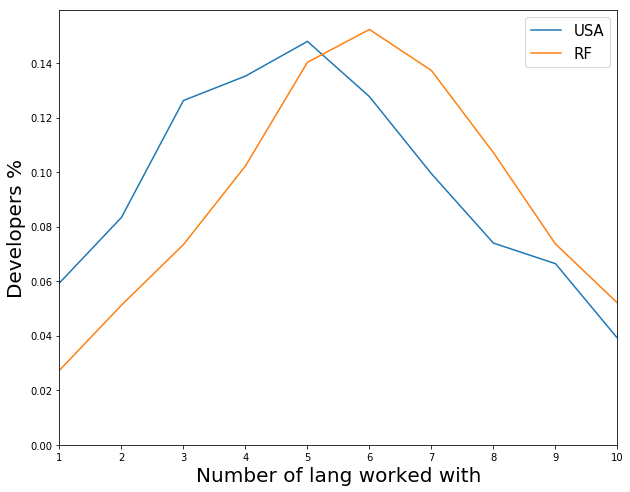

In [69]:
fig = plt.figure(figsize=(10,8)) 

(number_of_lang_users_rf / number_of_lang_users_rf.sum()).plot(label='USA', legend=True)
(number_of_lang_users_usa/ number_of_lang_users_usa.sum()).plot(label='RF', legend=True)

plt.xlabel('Number of lang worked with', size =20)
plt.ylabel('Developers %', size =20)
plt.ylim(ymin=0)
plt.xlim(xmax=10)
plt.legend(prop={'size': 15})

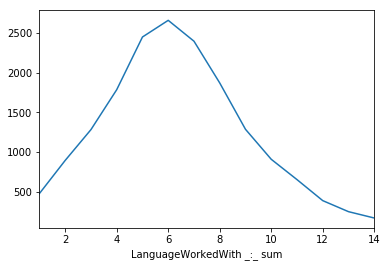

In [23]:
number_of_lang_users_usa.plot()

In [35]:
d = df[df['Country _:_ Russian Federation'] == 1.0].groupby('LanguageWorkedWith _:_ sum')
print(d.median()[d.size() > 100].ConvertedSalary.dropna().drop(0))

LanguageWorkedWith _:_ sum
1.0    21228.0
2.0    21960.0
3.0    18678.0
4.0    21228.0
5.0    21018.0
6.0    21228.0
7.0    23994.0
8.0    21228.0
9.0    22986.0
Name: ConvertedSalary, dtype: float64


In [36]:
d.std()[d.size() > 100].ConvertedSalary.dropna().drop(0)

LanguageWorkedWith _:_ sum
1.0     14530.937361
2.0     14622.782249
3.0     28094.406969
4.0     17837.601269
5.0     18638.453220
6.0     16230.754861
7.0     36767.245064
8.0    103068.250814
9.0     21855.628283
Name: ConvertedSalary, dtype: float64

In [70]:
auc_salary = dict()
for DevType in df.keys():
    if DevType.startswith('DevType'):
        auc_salary[DevType] = []
        for k in df.keys():
            if k.startswith('Country'):
                d = df[df[k] == 1.0]

                ds = d[d[DevType] == 1.0]
                not_ds = d[d[DevType] == 0.0]
                nds = np.array(not_ds.ConvertedSalary.dropna())
                ds = np.array(ds.ConvertedSalary.dropna())
                if (len(ds) > 50) and len(nds) > 500:
                    y = np.concatenate([np.ones(len(ds)), np.zeros(len(nds))])
                    salary = np.concatenate([ds, nds])
                    auc = roc_auc_score(y ,salary)
                    auc_salary[DevType].append((k.replace('Country _:_ ', ''),
                                                auc, np.median(salary), np.median(ds)))

In [89]:
dt.auc

country
Australia             0.474515
Brazil                0.574972
Canada                0.531368
France                0.536594
Germany               0.473067
India                 0.574570
Italy                 0.450814
Netherlands           0.508103
Poland                0.490951
Russian Federation    0.519881
Spain                 0.501746
Sweden                0.505176
United Kingdom        0.498862
United States         0.523704
Name: auc, dtype: float64

In [100]:
len(dt.index)

14

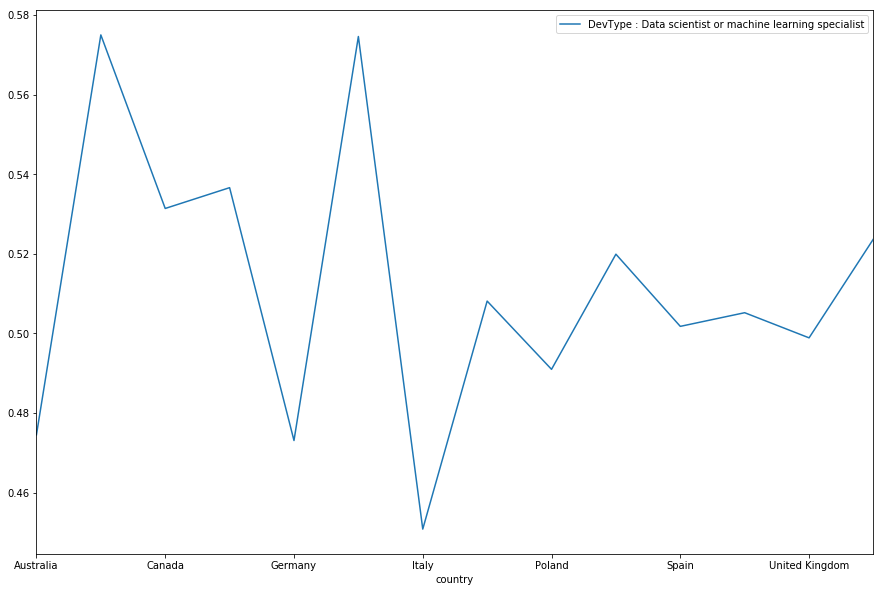

In [103]:
plt.figure(figsize=(15,10))
k ='DevType : Data scientist or machine learning specialist'
dt = pd.DataFrame(auc_salary[k], 
             columns=['country', 'auc', 'median_salary', 'median_salary_devtype']).set_index('country')
if len(dt) > 0:
    dt.auc.plot(legend=True, label=k)

In [96]:
DevType = 'DevType : Data scientist or machine learning specialist'
for k in df.keys():
    if k.startswith('Country'):
        d = df[df[k] == 1.0]

        ds = d[d[DevType] == 1.0]
        not_ds = d[d[DevType] == 0.0]
        nds = np.array(not_ds.ConvertedSalary.dropna())
        ds = np.array(ds.ConvertedSalary.dropna())
        if (len(ds) > 50) and len(nds) > 500:
            y = np.concatenate([np.ones(len(ds)), np.zeros(len(nds))])
            salary = np.concatenate([ds, nds])
            auc = roc_auc_score(y ,salary)
            print(k, auc, np.median(salary), np.median(ds))

('Country _:_ Australia', 0.4745150682650683, 79973.0, 76374.5)
('Country _:_ Brazil', 0.5749721238678378, 18720.0, 26196.0)
('Country _:_ Canada', 0.5313684353004873, 64417.0, 65513.5)
('Country _:_ France', 0.5365936420334725, 48955.0, 51403.0)
('Country _:_ Germany', 0.4730667223652303, 61194.0, 58752.0)
('Country _:_ India', 0.5745698430386323, 9396.0, 13200.0)
('Country _:_ Italy', 0.4508136094674557, 39164.0, 34880.5)
('Country _:_ Netherlands', 0.5081026058631921, 55075.0, 49011.5)
('Country _:_ Poland', 0.4909510974201001, 31764.0, 28236.0)
('Country _:_ Russian Federation', 0.5198805335678687, 21228.0, 22113.0)
('Country _:_ Spain', 0.50174611489436, 37695.5, 37940.0)
('Country _:_ Sweden', 0.5051763332514132, 58392.0, 58464.0)
('Country _:_ United Kingdom', 0.49886172986867117, 62507.0, 64382.0)
('Country _:_ United States', 0.523704194305882, 100000.0, 102500.0)


In [29]:
salarySet = df[df['ConvertedSalary'].fillna(0) > 0]

In [35]:
train_features = [key for key in salarySet.keys() if 'salary' not in key.lower()]

In [36]:
trn_x, trn_y = salarySet[train_features], salarySet['ConvertedSalary']

In [41]:
import lightgbm as lgb

reg = lgb.LGBMRegressor(
    num_leaves=31,
    learning_rate=0.03,
    n_estimators=1000,
    subsample=.9,
    colsample_bytree=.9,
    random_state=1
)
reg.fit(
    np.array(trn_x), np.array(trn_y),
    verbose=20,
    eval_metric='rmse'
)

LGBMRegressor(boosting_type='gbdt', colsample_bytree=0.9, learning_rate=0.03,
       max_bin=255, max_depth=-1, min_child_samples=10, min_child_weight=5,
       min_split_gain=0.0, n_estimators=1000, n_jobs=-1, num_leaves=31,
       objective=None, random_state=1, reg_alpha=0.0, reg_lambda=0.0,
       silent=True, subsample=0.9, subsample_for_bin=50000,
       subsample_freq=1)

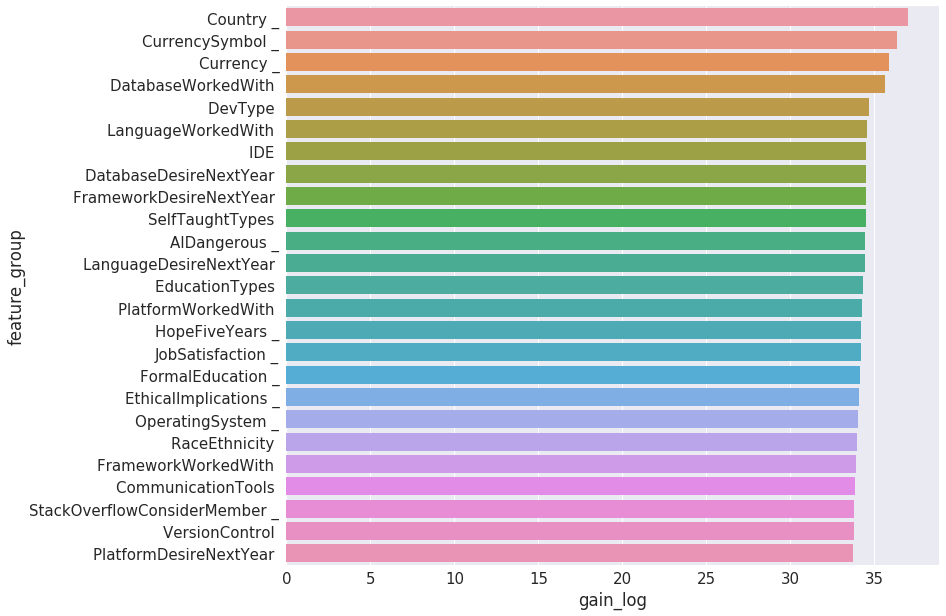

In [216]:
a4_dims = (11.7, 10.27)
fig, ax = plt.subplots(figsize=a4_dims)

imp_df = pd.DataFrame()
imp_df['feature'] = trn_x.columns
imp_df['gain'] = reg.booster_.feature_importance(importance_type='gain')

imp_df['feature'] = [x.decode('utf-8') for x in list(imp_df['feature'])]
imp_df['feature_group'] = imp_df['feature'].apply(lambda x: x.split(':')[0])
imp_gb = imp_df.groupby('feature_group')

plt_df = imp_gb.sum()[imp_gb.count() > 2]
plt_df['gain_log'] = np.log1p(plt_df['gain'])
plt_df = plt_df[plt_df['gain_log'] > 1]
#plt_df = plt_df[plt_df['gain_log'] > 1]      
sns.barplot(x='gain_log', y='feature_group', 
                data=plt_df.reset_index().sort_values('gain', ascending=False).iloc[:25])
sns.set(font_scale=1.5)

In [217]:
np.log1p(gr_df['gain'])# np.sign(c.corrwith(salarySet['ConvertedSalary']))

0    29.874301
1    32.109977
2    33.137447
3    34.006153
Name: gain, dtype: float64

In [218]:
log_gain = np.log1p(imp_df.set_index('feature')['gain'])

In [245]:
corr = salarySet[train_features].corrwith(salarySet['ConvertedSalary'])
corr.index = log_gain.index

In [282]:
imp_df = imp_df.reset_index()

In [294]:
imp_df = imp_df.set_index('feature')
imp_df['number'] = salarySet[train_features].sum()
imp_df = imp_df[imp_df['number'] > 50]
imp_df = imp_df[salarySet[train_features].sum()> 250]
imp_df['signed_gain * sign(corr)']=(np.sign(corr) * log_gain)[np.abs(corr) > 0.01]
imp_df = imp_df.reset_index()

/home/denis/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


/home/denis/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/home/denis/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


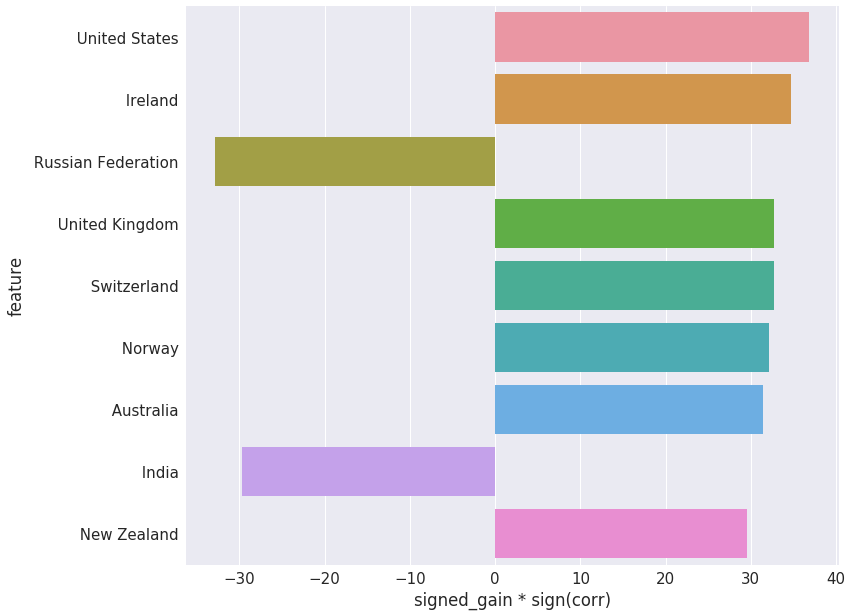

In [297]:
a4_dims = (11.7, 10.27)
sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=a4_dims)

gr_df = imp_df[imp_df['feature_group'] == 'Country _']
f_names=list(gr_df['feature'])
gr_df['gain_log'] = np.log1p(gr_df['gain'])
gr_df['feature'] = gr_df['feature'].apply(lambda x: x.split(':')[1].replace('_', ''))

gr_df = gr_df[np.abs(gr_df['signed_gain * sign(corr)']) > 1]      
sns.barplot(x='signed_gain * sign(corr)', y='feature', 
                data=gr_df.sort_values('gain', ascending=False).iloc[:30])


In [299]:
gr_df

,feature,index,gain,feature_group,signed_gain,signed_gain * sign(corr),number,gain_log


/home/denis/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/home/denis/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


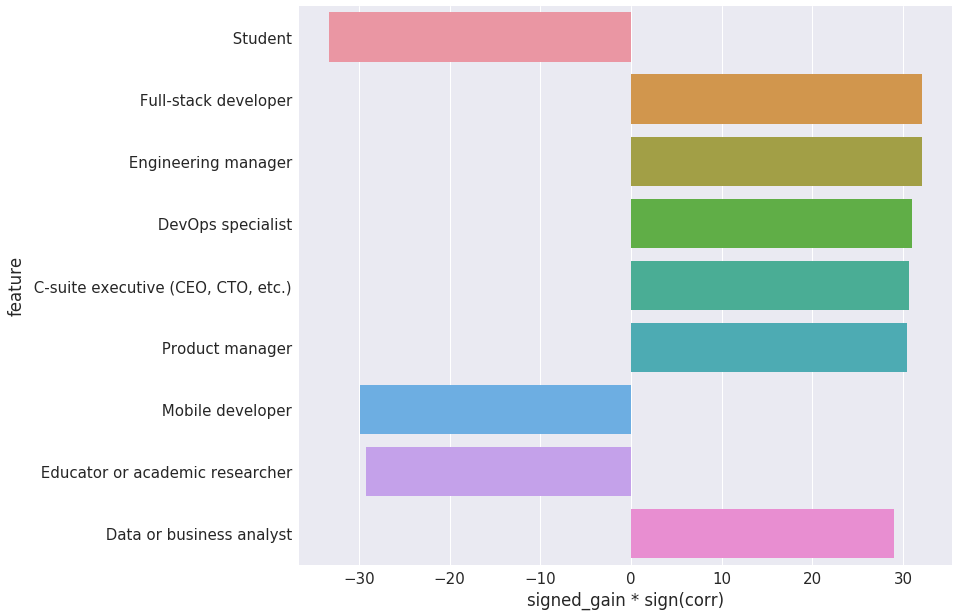

In [300]:
a4_dims = (11.7, 10.27)
sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=a4_dims)

gr_df = imp_df[imp_df['feature_group'] == 'DevType ']
f_names=list(gr_df['feature'])
gr_df['gain_log'] = np.log1p(gr_df['gain'])
gr_df['feature'] = gr_df['feature'].apply(lambda x: x.split(':')[1].replace('_', ''))

gr_df = gr_df[np.abs(gr_df['signed_gain * sign(corr)']) > 1]      
sns.barplot(x='signed_gain * sign(corr)', y='feature', 
                data=gr_df.sort_values('gain', ascending=False).iloc[:30])

/home/denis/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/denis/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


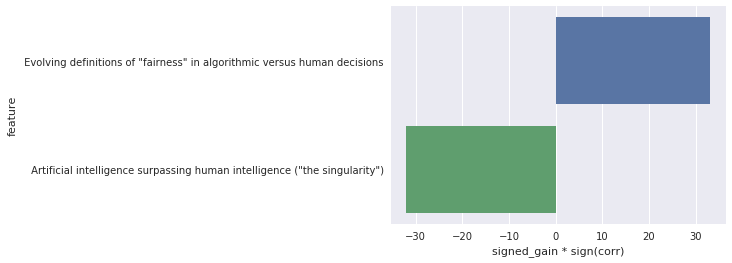

In [308]:
sns.set(font_scale=1.5)

gr_df = imp_df[imp_df['feature_group'] == 'AIDangerous _']
sns.set(font_scale=1.0)
f_names=list(gr_df['feature'])
gr_df['gain_log'] = np.log1p(gr_df['gain'])
gr_df['feature'] = gr_df['feature'].apply(lambda x: x.split(':')[1].replace('_', ''))

gr_df = gr_df[np.abs(gr_df['signed_gain * sign(corr)']) > 0.1]      
sns.barplot(x='signed_gain * sign(corr)', y='feature', 
                data=gr_df.sort_values('gain', ascending=False).iloc[:30])


/home/denis/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/denis/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


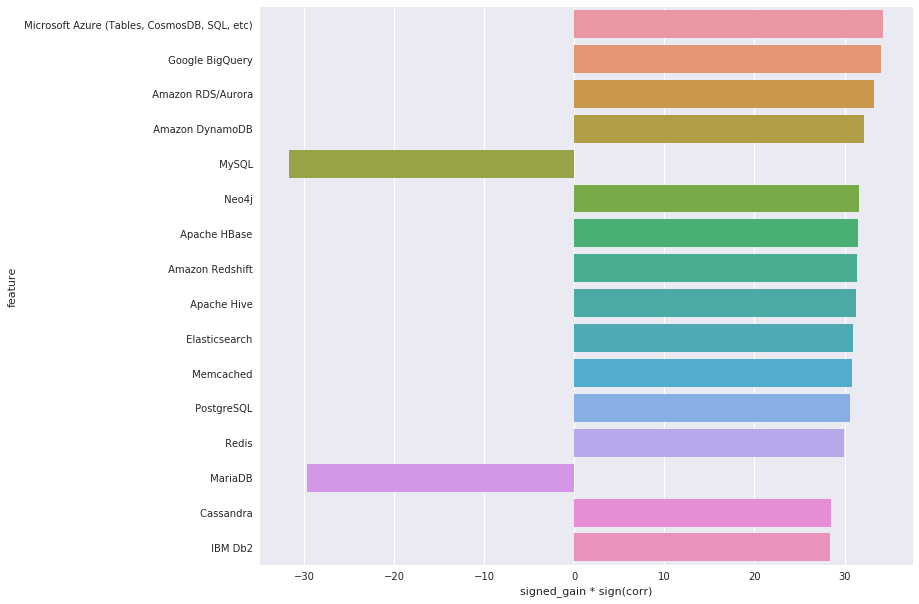

In [309]:
fig, ax = plt.subplots(figsize=a4_dims)
gr_df = imp_df[imp_df['feature_group'] == 'DatabaseWorkedWith ']
sns.set(font_scale=1.5)
f_names=list(gr_df['feature'])
gr_df['gain_log'] = np.log1p(gr_df['gain'])
gr_df['feature'] = gr_df['feature'].apply(lambda x: x.split(':')[1].replace('_', ''))

gr_df = gr_df[np.abs(gr_df['signed_gain * sign(corr)']) > 1]      
sns.barplot(x='signed_gain * sign(corr)', y='feature', 
                data=gr_df.sort_values('gain', ascending=False).iloc[:30])
